# Assigment

## Exploratory Data Analysis

In [390]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [391]:
# read data
X = pd.read_csv('data/TCGAdata.txt', delim_whitespace=True, index_col=0, header=0)
Y = pd.read_csv('data/TCGAlabels.txt', delim_whitespace=True, index_col=0, header=0)

# merge to have the dataset in one dataframe
data = pd.concat([X, Y], axis=1)

/tmp/ipykernel_35247/2748754953.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X = pd.read_csv('data/TCGAdata.txt', delim_whitespace=True, index_col=0, header=0)


/tmp/ipykernel_35247/2748754953.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  Y = pd.read_csv('data/TCGAlabels.txt', delim_whitespace=True, index_col=0, header=0)


In [392]:
#X

In [393]:
#Y

## Classes Distribution

<Axes: xlabel='x', ylabel='count'>

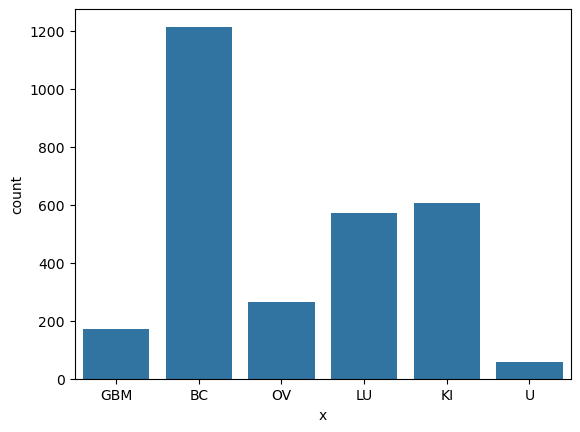

In [394]:
# hist of the class labels
sns.countplot(data=Y, x='x')

## Split Dataset, Define Classifiers and Folds

In [395]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

n_PCs = [500, 100, 50, 40, 35, 30, 25, 10]
n_top_features = [250, 225, 200, 175, 150, 100, 75, 50, 40, 35, 30]
n_neighbors = [1, 2, 3, 5, 8, 10, 50, 100, 300]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
knn = KNeighborsClassifier(weights='uniform')
logistic = LogisticRegression(class_weight='balanced', C=1e-10, random_state=42)
rf = RandomForestClassifier(n_estimators=50,  class_weight='balanced', random_state=42)
mlp = MLPClassifier(random_state=42, hidden_layer_sizes=(50, 50))

In [396]:
def apply_mislabeling(Y_train, percentage):
    num_samples = Y_train.shape[0]
    num_mislabeled_samples = int(num_samples * percentage)
    mislabeled_indices = np.random.choice(num_samples, num_mislabeled_samples, replace=False)
    for idx in mislabeled_indices:
        original_label = Y_train.iloc[idx]
        # ensure that the new label is different from the original one
        replacement_choices = np.setdiff1d([0, 1, 2, 3, 4, 5], [original_label])
        new_label = np.random.choice(replacement_choices)
        Y_train.iloc[idx] = new_label
    return Y_train

In [397]:
# setup and function for part 1 - task 1
parameters_1 = {
    'pca__n_components': n_PCs,
    'knn__n_neighbors': n_neighbors
}

pipeline_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', knn)
])

def train_test_for_pca(gaussian_noise_factor=0, mislabel_percentage=0, test_size=0.2):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42, stratify=Y)
    
    noise = np.random.normal(0, 1, Y_train.shape)
    X_train_noisy = X_train + gaussian_noise_factor * noise
    Y_train_mislabeled = apply_mislabeling(Y_train.copy(), mislabel_percentage)
    
    grid_search = GridSearchCV(pipeline_1, parameters_1, cv=stratified_k_fold, scoring='balanced_accuracy', n_jobs=-1)
    grid_search.fit(X_train_noisy, np.ravel(Y_train_mislabeled))
    print(grid_search.best_params_)
    print(grid_search.best_score_)    
    
    return grid_search, X_test, Y_test

## Train Dataset and Get Test Accuracy (Logistic)

In [398]:
pipeline_0 = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', logistic)])

def test_train_logistic(gaussian_noise_factor=0):
    print('gaussian_noise_factor: ', gaussian_noise_factor)
    noise = np.random.normal(0, 1, Y_train.shape)
    X_train_noisy = X_train + gaussian_noise_factor * noise    
    
    print('X_train_noisy.shape: ', X_train_noisy.shape)
    print('X_test.shape: ', X_test.shape)
    pipeline_0.fit(X_train_noisy, np.ravel(Y_train))
    Y_test_pred_0 = pipeline_0.predict(X_test)
    print('logistic accuracy score: ', balanced_accuracy_score(Y_test, Y_test_pred_0))
    print('classification report: \n', classification_report(Y_test, Y_test_pred_0))
    print('\n\n')
    
test_train_logistic()  

gaussian_noise_factor:  0
X_train_noisy.shape:  (2309, 2000)
X_test.shape:  (578, 2000)


logistic accuracy score:  0.9127836272492033
classification report: 
               precision    recall  f1-score   support

          BC       1.00      0.67      0.81       243
         GBM       0.89      0.97      0.93        35
          KI       0.93      0.98      0.96       121
          LU       0.94      0.90      0.92       114
          OV       0.91      0.94      0.93        53
           U       0.14      1.00      0.25        12

    accuracy                           0.83       578
   macro avg       0.80      0.91      0.80       578
weighted avg       0.94      0.83      0.87       578






## Train Dataset and Get Test Accuracy (RF)

In [399]:
pipeline_0 = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', rf)])

def test_train_rf(gaussian_noise_factor=0):
    print('gaussian_noise_factor: ', gaussian_noise_factor)
    noise = np.random.normal(0, 1, Y_train.shape)
    X_train_noisy = X_train + gaussian_noise_factor * noise    
    
    print('X_train_noisy.shape: ', X_train_noisy.shape)
    print('X_test.shape: ', X_test.shape)
    pipeline_0.fit(X_train_noisy, np.ravel(Y_train))
    Y_test_pred_0 = pipeline_0.predict(X_test)
    print('logistic accuracy score: ', balanced_accuracy_score(Y_test, Y_test_pred_0))
    print('classification report: \n', classification_report(Y_test, Y_test_pred_0))
    print('\n\n')
    
test_train_rf()  

gaussian_noise_factor:  0
X_train_noisy.shape:  (2309, 2000)
X_test.shape:  (578, 2000)
logistic accuracy score:  0.9739031651846495
classification report: 
               precision    recall  f1-score   support

          BC       0.98      1.00      0.99       243
         GBM       1.00      0.97      0.99        35
          KI       1.00      0.99      1.00       121
          LU       1.00      0.98      0.99       114
          OV       1.00      0.98      0.99        53
           U       1.00      0.92      0.96        12

    accuracy                           0.99       578
   macro avg       1.00      0.97      0.98       578
weighted avg       0.99      0.99      0.99       578






## Train Dataset and Get Test Accuracy (MLP)

In [400]:
pipeline_0 = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', mlp)])

def test_train_mlp(gaussian_noise_factor=0):
    print('gaussian_noise_factor: ', gaussian_noise_factor)
    noise = np.random.normal(0, 1, Y_train.shape)
    X_train_noisy = X_train + gaussian_noise_factor * noise    
    
    print('X_train_noisy.shape: ', X_train_noisy.shape)
    print('X_test.shape: ', X_test.shape)
    pipeline_0.fit(X_train_noisy, np.ravel(Y_train))
    Y_test_pred_0 = pipeline_0.predict(X_test)
    print('logistic accuracy score: ', balanced_accuracy_score(Y_test, Y_test_pred_0))
    print('classification report: \n', classification_report(Y_test, Y_test_pred_0))
    print('\n\n')
    
test_train_mlp()  

gaussian_noise_factor:  0
X_train_noisy.shape:  (2309, 2000)
X_test.shape:  (578, 2000)
logistic accuracy score:  0.9953933576078561
classification report: 
               precision    recall  f1-score   support

          BC       1.00      1.00      1.00       243
         GBM       1.00      1.00      1.00        35
          KI       0.99      1.00      1.00       121
          LU       1.00      0.99      1.00       114
          OV       1.00      0.98      0.99        53
           U       0.92      1.00      0.96        12

    accuracy                           1.00       578
   macro avg       0.99      1.00      0.99       578
weighted avg       1.00      1.00      1.00       578






## Train Dataset and Get Test Accuracy (KNN)

In [401]:
from sklearn.metrics import balanced_accuracy_score, classification_report


def test_train_knn(gaussian_noise_factor=0):
    noise = np.random.normal(0, 1, X_train.shape)
    X_train_noisy = X_train + gaussian_noise_factor * noise
    pipeline_0 = Pipeline(steps=[('scaler', StandardScaler()), ('knn', knn)])

    best_score = 0
    best_k = 0

    for k in n_neighbors:
        # knn.set_params(n_neighbors=k)
        pipeline_0.set_params(knn__n_neighbors=k)
        pipeline_0.fit(X_train_noisy, np.ravel(Y_train))
        
        Y_pred = pipeline_0.predict(X_train_noisy)
        score = balanced_accuracy_score(Y_train, Y_pred)
        
        if  score > best_score:
            best_score = score
            best_k = k
        
        pipeline_0.fit(X_train_noisy, np.ravel(Y_train))
        Y_test_pred_0 = pipeline_0.predict(X_test)
        print(k, score, balanced_accuracy_score(Y_test, Y_test_pred_0))
        print(classification_report(Y_test, Y_test_pred_0))
        print('\n\n')
        
    print('\n\n')
    print('Best training k:', best_k)
    print('Best training score:', best_score)

In [402]:
test_train_knn(0.9)

1 1.0 0.9756049936942778
              precision    recall  f1-score   support

          BC       0.98      1.00      0.99       243
         GBM       1.00      1.00      1.00        35
          KI       1.00      0.98      0.99       121
          LU       1.00      0.99      1.00       114
          OV       0.98      0.96      0.97        53
           U       1.00      0.92      0.96        12

    accuracy                           0.99       578
   macro avg       0.99      0.98      0.98       578
weighted avg       0.99      0.99      0.99       578




2 0.9755786253384716 0.9602541165012952
              precision    recall  f1-score   support

          BC       0.97      1.00      0.99       243
         GBM       1.00      1.00      1.00        35
          KI       1.00      0.98      0.99       121
          LU       1.00      0.98      0.99       114
          OV       0.98      0.96      0.97        53
           U       1.00      0.83      0.91        12

    accur

/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## Part 1 - Dimension reduction and predictive modeling

### Assume optimal number of PC.

In [403]:
from sklearn.model_selection import StratifiedKFold


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2000)  
principal_components = pca.fit_transform(X_scaled)

explained_variance_ratios = pca.explained_variance_ratio_
cumulative_variance_ratios = np.cumsum(pca.explained_variance_ratio_)

n_components_80 = len(cumulative_variance_ratios[cumulative_variance_ratios <= 0.8]) + 1
print(f"Number of components needed to explain 80% variance: {n_components_80}")
n_components_50 = len(cumulative_variance_ratios[cumulative_variance_ratios <= 0.5]) + 1
print(f"Number of components needed to explain 50% variance: {n_components_50}")

Number of components needed to explain 80% variance: 226
Number of components needed to explain 50% variance: 15


<Axes: >

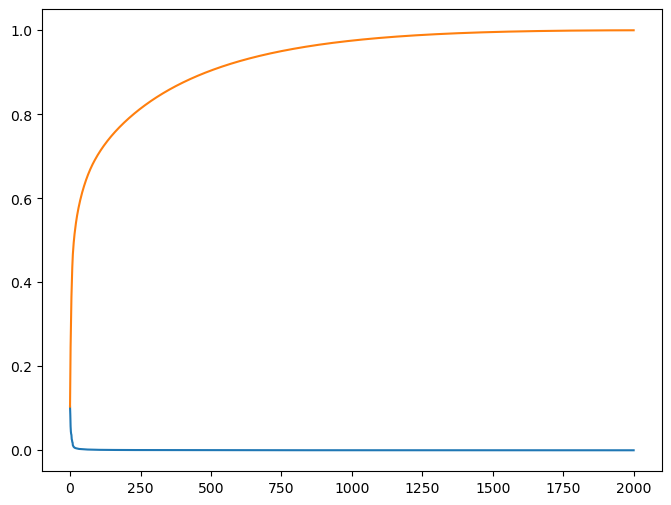

In [404]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=pca.explained_variance_ratio_)
sns.lineplot(data=cumulative_variance_ratios)

In [405]:
Y['x'].unique()
# assign a numbered label for Y
label_map = {'GBM': 0, 'BC': 1, 'OV': 2, 'LU': 3, 'KI': 4, 'U': 5}
Y['x'] = Y['x'].map(label_map)

### Task 1: Perform cross-validation to select the number of principal components that optimizing predictive performance.

In [406]:
def train_test_for_pca(gaussian_noise_factor=0, mislabel_percentage=0, test_size=0.2):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42, stratify=Y)
    
    noise = np.random.normal(0, 1, Y_train.shape)
    X_train_noisy = X_train + gaussian_noise_factor * noise
    Y_train_mislabeled = apply_mislabeling(Y_train.copy(), mislabel_percentage)
    
    grid_search = GridSearchCV(pipeline_1, parameters_1, cv=stratified_k_fold, scoring='balanced_accuracy', n_jobs=-1)
    grid_search.fit(X_train_noisy, np.ravel(Y_train_mislabeled))
    print(grid_search.best_params_)
    print(grid_search.best_score_)    
    
    return grid_search, X_test, Y_test

def task1(X_train, Y_train):
    grid_search_1.best_estimator_
    

    return cv_results, mean_test_scores, params, neighbors, components

def classification_report(grid_search_1, X_test, Y_test, Y_test_pred_1):
    Y_test_pred_1 = grid_search_1.predict(X_test)
    best_params_1 = grid_search_1.best_params_
    print("Classification Report \nOptimal parameters - ",
        best_params_1['knn__n_neighbors'], " neighbors and ",
        best_params_1['pca__n_components'], "principal components:\n\n",
        classification_report(Y_test, Y_test_pred_1))
    


In [407]:
from sklearn.metrics import classification_report, confusion_matrix

task1()

Classification Report 
Optimal parameters -  1  neighbors and  40 principal components:

               precision    recall  f1-score   support

          BC       0.99      1.00      0.99       243
         GBM       1.00      1.00      1.00        35
          KI       0.99      0.99      0.99       121
          LU       0.99      0.98      0.99       114
          OV       1.00      0.98      0.99        53
           U       0.92      1.00      0.96        12

    accuracy                           0.99       578
   macro avg       0.98      0.99      0.99       578
weighted avg       0.99      0.99      0.99       578



({'mean_fit_time': array([3.53985195, 1.65795927, 0.95453787, 0.72968345, 0.78947439,
         0.74260645, 0.74887953, 0.64104872, 3.58409953, 1.33734694,
         0.87379608, 0.75096374, 0.80343027, 0.73430419, 0.78812375,
         0.73424411, 3.35799441, 1.34448929, 0.81397748, 0.764538  ,
         0.80886106, 0.75855746, 0.71882315, 0.58150663, 3.45546188,
         1.31077919, 0.81466379, 0.76123686, 0.76592994, 0.72794375,
         0.70601072, 0.68229465, 3.22315025, 1.31749444, 0.86789465,
         0.77121272, 0.84649849, 0.73609705, 0.74724493, 0.6402967 ,
         3.27530713, 1.36349454, 0.82361894, 0.789607  , 0.80005159,
         0.77791781, 0.70477538, 0.61219845, 3.29460864, 1.37359457,
         0.824263  , 0.79868569, 0.7408937 , 0.75962467, 0.78240995,
         0.64353471, 3.38394341, 1.26138554, 0.82491097, 0.75724845,
         0.79168963, 0.82050333, 0.71447048, 0.57881856, 3.29019332,
         1.35449071, 0.75794678, 0.82092009, 0.75315933, 0.75887074,
         0.729675

Classification Report 
Optimal parameters -  1  neighbors and  40 principal components:

               precision    recall  f1-score   support

          BC       1.00      1.00      1.00       243
         GBM       1.00      1.00      1.00        35
          KI       0.99      0.99      0.99       121
          LU       0.98      0.99      0.99       114
          OV       1.00      0.96      0.98        53
           U       0.85      0.92      0.88        12

    accuracy                           0.99       578
   macro avg       0.97      0.98      0.97       578
weighted avg       0.99      0.99      0.99       578



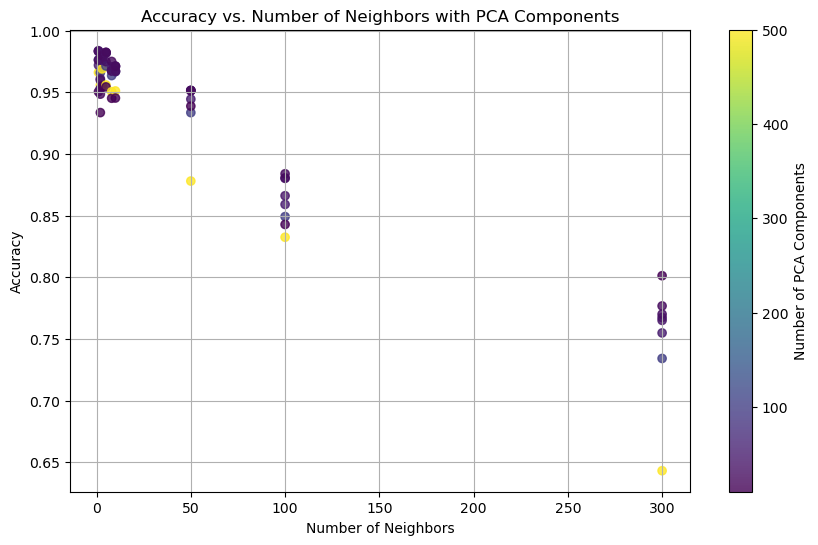

In [408]:
import matplotlib.pyplot as plt

cv_results, mean_test_scores, params, neighbors, components = task1()

def plot_accuracy_vs_nr_neighbors(cv_results, mean_test_scores, params, neighbors, components):
    plt.figure(figsize=(10, 6))
    plt.scatter(neighbors, mean_test_scores, c=components, cmap='viridis', alpha=0.8)
    plt.colorbar(label='Number of PCA Components')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Neighbors with PCA Components')
    plt.grid(True)
    plt.show()

plot_accuracy_vs_nr_neighbors(cv_results, mean_test_scores, params, neighbors, components)

Classification Report 
Optimal parameters -  1  neighbors and  40 principal components:

               precision    recall  f1-score   support

          BC       1.00      1.00      1.00       243
         GBM       1.00      1.00      1.00        35
          KI       0.99      0.99      0.99       121
          LU       0.98      0.99      0.99       114
          OV       1.00      0.98      0.99        53
           U       0.92      0.92      0.92        12

    accuracy                           0.99       578
   macro avg       0.98      0.98      0.98       578
weighted avg       0.99      0.99      0.99       578



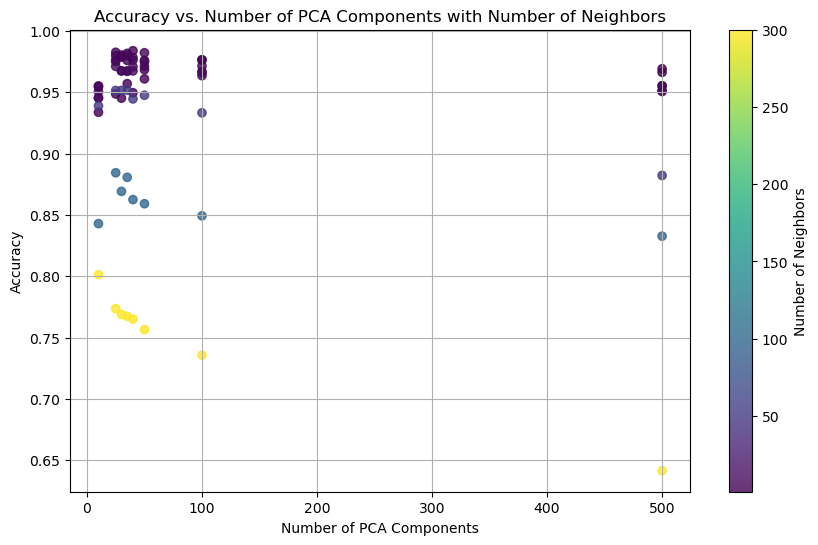

In [409]:
import matplotlib.pyplot as plt

cv_results, mean_test_scores, params, neighbors, components = task1()

def plot_accuracy_vs_nr_neighbors(cv_results, mean_test_scores, params, neighbors, components):
    plt.figure(figsize=(10, 6))
    plt.scatter(components, mean_test_scores, c=neighbors, cmap='viridis', alpha=0.8)
    plt.colorbar(label='Number of Neighbors')
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of PCA Components with Number of Neighbors')
    plt.grid(True)
    plt.show()

plot_accuracy_vs_nr_neighbors(cv_results, mean_test_scores, params, neighbors, components)

### Task 2: Perform cross-validation to select the number features (genes) that optimizing predictive performance.

In [410]:
# Create the RFECV model
from sklearn.feature_selection import RFECV
from sklearn.datasets import load_digits
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif

classifier = knn

parameters_2 = {
    'kbest__k': n_top_features,
    'knn__n_neighbors': n_neighbors
}

pipeline_2 = Pipeline([
    ('th', VarianceThreshold()),
    ('scaler', StandardScaler()),
    ('kbest', SelectKBest(score_func=f_classif)),
    ('classifier', knn)
])




In [411]:
from sklearn.metrics import classification_report, confusion_matrix

grid_search_2 = GridSearchCV(pipeline_2, parameters_2, cv=stratified_k_fold, n_jobs=-1, scoring="balanced_accuracy")
grid_search_2.fit(X_train, np.ravel(Y_train))

Y_test_pred_2 = grid_search_2.predict(X_test)
grid_search_2.best_estimator_
best_params_2 = grid_search_2.best_params_
print("Classification Report \nOptimal parameters - ",
      best_params_2['classifier__n_neighbors'], " neighbors and ",
      best_params_2['kbest__k'], "variables:\n\n",
      classification_report(Y_test, Y_test_pred_2))

Classification Report 
Optimal parameters -  3  neighbors and  200 variables:

               precision    recall  f1-score   support

          BC       0.98      1.00      0.99       243
         GBM       1.00      1.00      1.00        35
          KI       1.00      0.99      1.00       121
          LU       1.00      0.99      1.00       114
          OV       1.00      0.98      0.99        53
           U       0.91      0.83      0.87        12

    accuracy                           0.99       578
   macro avg       0.98      0.97      0.97       578
weighted avg       0.99      0.99      0.99       578



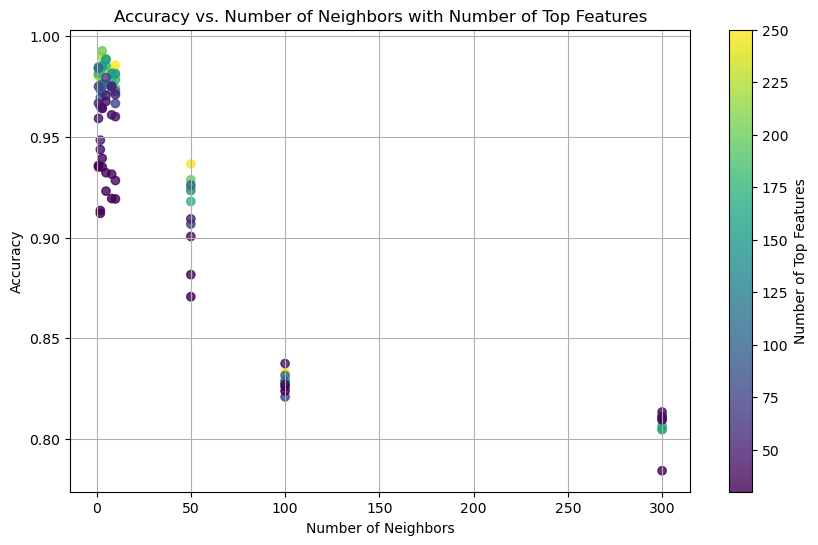

In [412]:
import matplotlib.pyplot as plt

cv_results = grid_search_2.cv_results_

mean_test_scores = cv_results['mean_test_score']
params = cv_results['params']

neighbors = [params[i]['knn__n_neighbors'] for i in range(len(params))]
components = [params[i]['kbest__k'] for i in range(len(params))]

# Plot 
plt.figure(figsize=(10, 6))
plt.scatter(neighbors, mean_test_scores, c=components, cmap='viridis', alpha=0.8)
plt.colorbar(label='Number of Top Features')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors with Number of Top Features')
plt.grid(True)
plt.show()

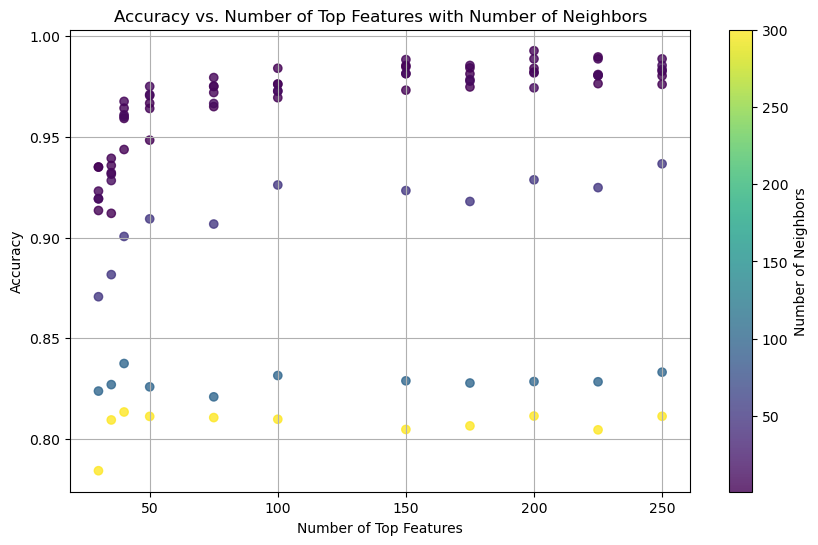

In [413]:
import matplotlib.pyplot as plt

cv_results = grid_search_2.cv_results_

mean_test_scores = cv_results['mean_test_score']
params = cv_results['params']

neighbors = [params[i]['knn__n_neighbors'] for i in range(len(params))]
components = [params[i]['kbest__k'] for i in range(len(params))]

# Plot 
plt.figure(figsize=(10, 6))
plt.scatter(components, mean_test_scores, c=neighbors, cmap='viridis', alpha=0.8)
plt.colorbar(label='Number of Neighbors')
plt.xlabel('Number of Top Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Top Features with Number of Neighbors')
plt.grid(True)
plt.show()

## Wrap-Up of Part 1

In [414]:
print("Top Principal Components:\nOptimal parameters - ",
      best_params_1['knn__n_neighbors'], " neighbors and ",
      best_params_1['pca__n_components'], "principal components:\n\n",
      classification_report(Y_test, Y_test_pred_1))

print("Top Features:\nOptimal parameters - ",
      best_params_2['knn__n_neighbors'], " neighbors and ",
      best_params_2['kbest__k'], "variables:\n\n",
      classification_report(Y_test, Y_test_pred_2))

Top Principal Components:
Optimal parameters -  1  neighbors and  40 principal components:

               precision    recall  f1-score   support

          BC       1.00      1.00      1.00       243
         GBM       1.00      1.00      1.00        35
          KI       0.99      0.99      0.99       121
          LU       0.98      0.99      0.99       114
          OV       1.00      0.98      0.99        53
           U       0.92      0.92      0.92        12

    accuracy                           0.99       578
   macro avg       0.98      0.98      0.98       578
weighted avg       0.99      0.99      0.99       578

Top Features:
Optimal parameters -  3  neighbors and  200 variables:

               precision    recall  f1-score   support

          BC       0.98      1.00      0.99       243
         GBM       1.00      1.00      1.00        35
          KI       1.00      0.99      1.00       121
          LU       1.00      0.99      1.00       114
          OV       1.0

In [415]:
# def train_test_cv_pca():
  

## Part 2: mislabeling

In [416]:
def apply_mislabeling(Y_train, percentage):
    num_samples = Y_train.shape[0]
    num_mislabeled_samples = int(num_samples * percentage)
    mislabeled_indices = np.random.choice(num_samples, num_mislabeled_samples, replace=False)
    for idx in mislabeled_indices:
        original_label = Y_train.iloc[idx]
        # ensure that the new label is different from the original one
        replacement_choices = np.setdiff1d([0, 1, 2, 3, 4, 5], [original_label])
        new_label = np.random.choice(replacement_choices)
        Y_train.iloc[idx] = new_label
    return Y_train

In [417]:
def train_test_knn_mislabel(gaussian_noise_factor=0):
    noise = np.random.normal(0, 1, X_train.shape)
    X_train_noisy = X_train + gaussian_noise_factor * noise
    
    pipeline_0 = Pipeline(steps=[('scaler', StandardScaler()), ('knn', knn)])

    mislabeling_percs = [0.01, 0.05, 0.08, 0.1, 0.12, 0.15, 0.18, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    plt.figure(figsize=(10, 8))
    for k in n_neighbors:
        mislabeling_results = []
        for percentage in mislabeling_percs:
            Y_train_mislabel = Y_train.copy()
            Y_train_mislabel = apply_mislabeling(Y_train_mislabel, percentage)
            pipeline_0.set_params(knn__n_neighbors=k)
            pipeline_0.fit(X_train_noisy, np.ravel(Y_train_mislabel))
            Y_test_pred_0 = pipeline_0.predict(X_test)
            mislabeling_results.append(balanced_accuracy_score(Y_test, Y_test_pred_0))
            
        # plot the results
        plt.plot(mislabeling_percs, mislabeling_results, label=f'k={k}')
        plt.xlabel('Percentage of mislabeled samples')
        plt.ylabel('Balanced accuracy')
        plt.legend()

        
train_test_knn_mislabel(0.9)

UFuncTypeError: ufunc 'greater' did not contain a loop with signature matching types (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.StrDType'>) -> None

<Figure size 1000x800 with 0 Axes>

In [ ]:
# redo task 1 with different percentage of mislabeling